**ML Model for Aker Sykehus for Predicting Rehabilitation of Patients**

Installing libraries if needed

In [ ]:
!python --version

Python 3.10.12


Importing libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from collections import defaultdict
import pickle
import json
%matplotlib inline

Defining batchsize and epochs for training

Mount Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading the dataset with patient test results and the best hyperparameters from Google Drive


In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict
import pickle

# Function to load data
def load_data(file_path):
    df = pd.read_excel(file_path)
    df.set_index("#", inplace=True)
    return df

# Preprocessing functions
def apply_preprocessing(data, preprocessing_type):
    if preprocessing_type == 'standard':
        scaler = StandardScaler()
    elif preprocessing_type == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def preprocess_patient_data(patient_data, test_name, preprocessing_type):
    test_columns = [col for col in patient_data.columns if col.startswith(test_name)]
    change_columns = [col for col in patient_data.columns if "CHANGE" in col]
    patient_test = patient_data[test_columns + change_columns]
    patient_test = patient_test.apply(pd.to_numeric, errors='coerce')
    patient_test = patient_test.dropna(axis=1, how='all')
    if patient_test.empty:
        return None, None
    patient_test_scaled, scaler = apply_preprocessing(np.array(patient_test).T, preprocessing_type)
    return patient_test_scaled, scaler

# ML model creation
def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=(None, 1)))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer)
    return model

# ML model training
def train_model(model, X_train, y_train, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])
    return model, history

# Prediction and evaluation
def predict_and_evaluate(model, X_test, y_test, scaler):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    actual_value = scaler.inverse_transform(y_test.reshape(-1, 1))
    return prediction[0][0], actual_value[0][0]

# Load the dataset
file_path = '/content/gdrive/My Drive/Colab Notebooks/ML model/PT OM change scores - anonymous.xlsx'
df = load_data(file_path)

# Extract unique patient IDs just once
patient_ids = df.index.unique()

# Load best hyperparameters
with open('/content/gdrive/My Drive/Colab Notebooks/ML model/best_hyperparameters2.pickle', 'rb') as f:
    best_hyperparameters = pickle.load(f)


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Pre-modeling Correlation Analysis

<ipython-input-34-ef022c5b7b09>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_subset = subset_df.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


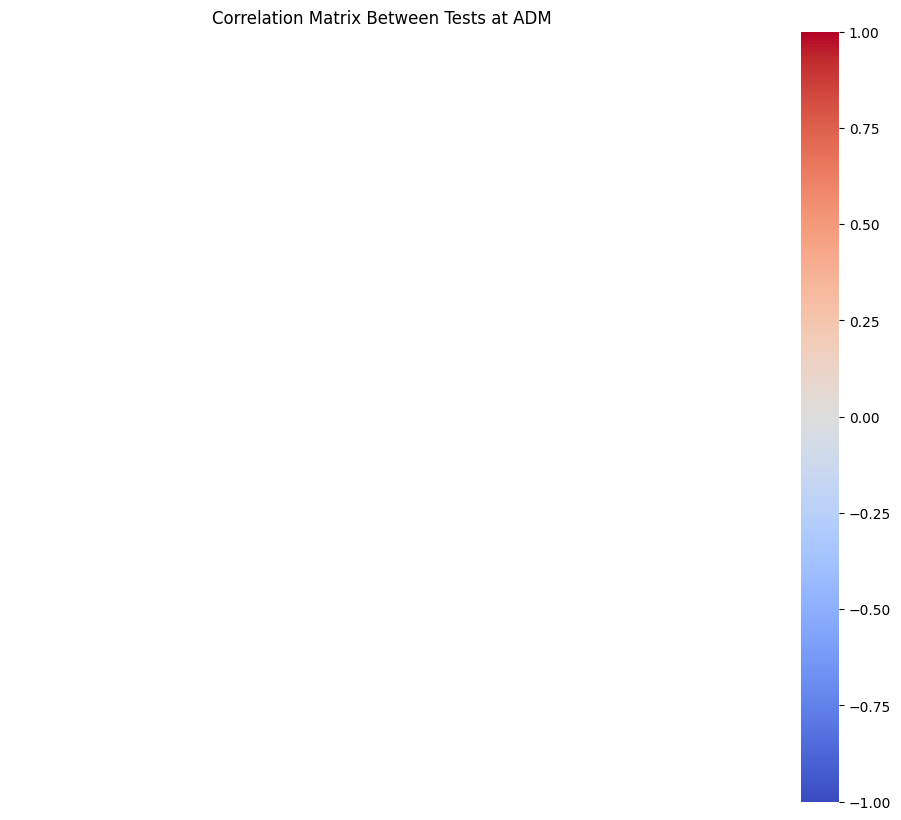

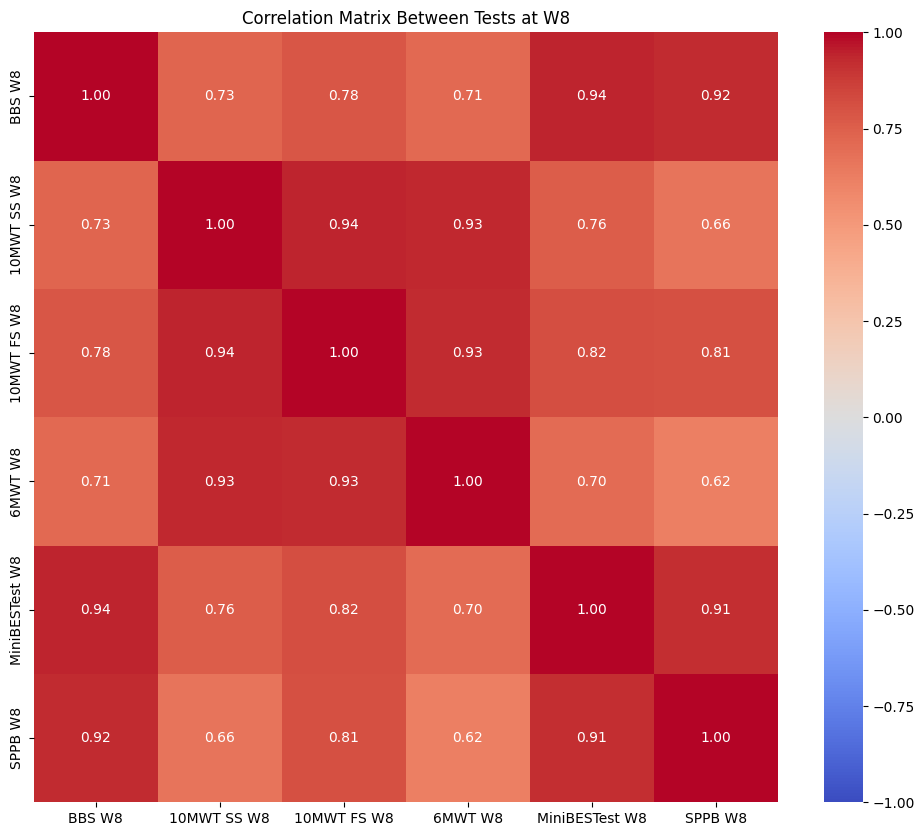

<ipython-input-34-ef022c5b7b09>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix_subset = subset_df.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


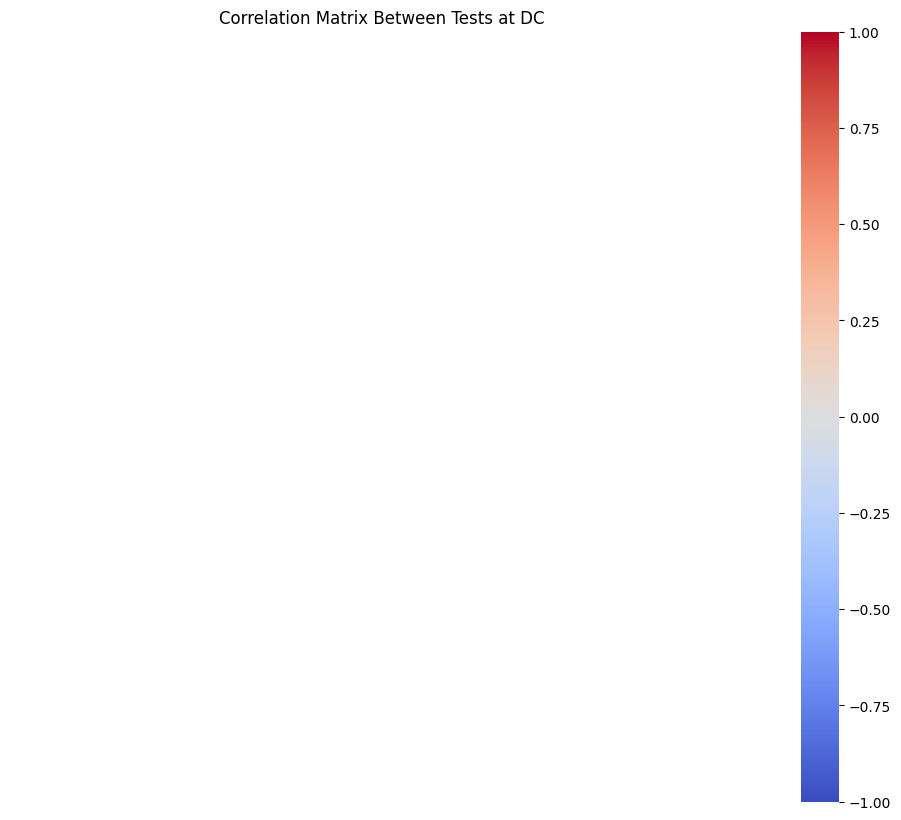

In [34]:
def visualize_test_correlation_at_timepoints(df):
    timepoints = ["ADM", "W8", "DC"]

    for timepoint in timepoints:
        # Filter columns corresponding to the current timepoint tests
        cols = [col for col in df.columns if timepoint in col and 'change' not in col.lower()]
        subset_df = df[cols]

        # Compute the correlation matrix for the subset
        corr_matrix_subset = subset_df.corr()

        # Visualize the subset correlation matrix using a heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 10})
        plt.title(f'Correlation Matrix Between Tests at {timepoint}')
        plt.show()

visualize_test_correlation_at_timepoints(df)


Defining functions for RNN Model

In [35]:
#Preprocessing

def apply_preprocessing(data, preprocessing_type):
    if preprocessing_type == 'standard':
        scaler = StandardScaler()
    elif preprocessing_type == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def preprocess_patient_data(patient_data, test_name, preprocessing_type):
    # Get the columns for this test
    test_columns = [col for col in patient_data.columns if col.startswith(test_name)]
    change_columns = [col for col in patient_data.columns if "CHANGE" in col]

    # Combine target and change-related columns
    patient_test = patient_data[test_columns + change_columns]

    # Convert non-numeric values to NaN
    patient_test = patient_test.apply(pd.to_numeric, errors='coerce')

    # Drop missing values
    patient_test = patient_test.dropna(axis=1, how='all')

    # Check if patient_test is empty
    if patient_test.empty:
        return None, None

    # Apply preprocessing using the new function
    patient_test_scaled, scaler = apply_preprocessing(np.array(patient_test).T, preprocessing_type)

    return patient_test_scaled, scaler


#ML model creation

def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=(None, 1)))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer)
    return model

#ML model training

def train_model(model, X_train, y_train, batch_size, epochs):
    early_stopping = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stopping])
    return model, history


#Prediction and evaluation

def predict_and_evaluate(model, X_test, y_test, scaler):
    # Make the prediction
    prediction = model.predict(X_test)

    # Invert predictions to original scale for interpretation
    prediction = scaler.inverse_transform(prediction)
    actual_value = scaler.inverse_transform(y_test.reshape(-1, 1))

    return prediction[0][0], actual_value[0][0]


Defining functions for ETS Model

Defining functions for the Naïve Forecast Model

In [36]:
# Updated Naive Forecast function to implement Average Naive Baseline
def run_average_naive_forecast(patient_data, test_name, n=3):
    # Get the columns for this test
    test_columns = [col for col in patient_data.columns if col.startswith(test_name)]

    # Extract test-specific data for this patient (row-wise)
    patient_test_data = patient_data[test_columns].iloc[0]

    # Drop NaN values
    patient_test_data = patient_test_data.dropna()

    # Check if there's enough data for a naive forecast
    if len(patient_test_data) < n + 1:
        print(f"Insufficient data for Average Naive Forecast for {test_name}. Need at least {n+1} observations.")
        return None, None

    # Create the average naive forecast and corresponding actual values
    naive_forecast = [np.mean(patient_test_data[i-n:i]) for i in range(n, len(patient_test_data))]
    actual_values = patient_test_data[n:].values

    return np.array(naive_forecast), actual_values


Data cleaning and preprocessing, including handling of missing values, possible skewness, data exploration and feature engineering

In [37]:
print("Columns in dataset:", df.columns)

Columns in dataset: Index(['BBS ADM', '10MWT SS ADM', '10MWT FS ADM', '6MWT ADM',
       'MiniBESTest ADM', 'SPPB ADM', 'BBS W1', 'BBS CHANGE ADM-W1',
       '10MWT SS W1', '10MWT SS CHANGE ADM-W1',
       ...
       '10MWT SS DC', '10MWT SS CHANGE ADM-DC', '10MWT FS DC',
       '10MWT FS CHANGE ADM-DC', '6MWT DC', '6MWT CHANGE ADM-DC',
       'MiniBESTest DC', 'MiniBESTest CHANGE ADM-DC', 'SPPB DC',
       'SPPB CHANGE ADM-DC'],
      dtype='object', length=174)


In [38]:
print("Number of rows (patients (including column names)): %d, and number of columns (tests and results): %d" % df.shape)

Number of rows (patients (including column names)): 201, and number of columns (tests and results): 174


In [39]:
df.head

<bound method NDFrame.head of       BBS ADM 10MWT SS ADM 10MWT FS ADM 6MWT ADM MiniBESTest ADM SPPB ADM  \
#                                                                           
1.0        46         0.88         1.14      324              17      NaN   
2.0        48         0.86         1.56      468              11      NaN   
3.0        30         0.22         0.36      113               4      NaN   
4.0         1            0            0        0               0      NaN   
5.0        42         0.73         0.86      210              10      NaN   
...       ...          ...          ...      ...             ...      ...   
196.0     NaN          NaN          NaN      NaN             NaN      NaN   
197.0      46     0.440529     0.637552      203              15        8   
198.0       3            0            0        0               0        0   
199.0      44     0.653808     0.703977      198               7        2   
200.0      48     1.292825     1.730104      4

In [40]:
df.describe()

,BBS W1,SPPB CHANGE ADM-W1,BBS CHANGE W1-W2,10MWT SS CHANGE W1-W2,10MWT FS CHANGE W1-W2,6MWT CHANGE W1-W2,MiniBESTest CHANGE W1-W2,SPPB CHANGE W1-W2,BBS W3,BBS CHANGE W2-W3,...,10MWT SS W13,10MWT SS CHANGE W12-W13,10MWT FS W13,10MWT FS CHANGE W12-W13,6MWT W13,6MWT CHANGE W12-W13,MiniBESTest W13,MiniBESTest CHANGE W12-W13,SPPB W13,SPPB CHANGE W12-W13
count,156.000000,117.000000,107.000000,107.000000,100.000000,101.000000,106.000000,81.000000,83.000000,75.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
mean,32.942308,0.829060,3.121495,0.069158,0.092471,22.633663,1.264151,0.419753,29.337349,1.706667,...,0.539665,0.079366,0.524109,-0.085833,173.0,-6.0,6.0,5.0,5.0,4.0
std,16.288623,1.428108,3.939903,0.109496,0.146151,35.359503,2.015662,1.404139,15.638662,3.941372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,-3.000000,-7.000000,-0.205857,-0.370143,-89.000000,-3.000000,-6.000000,1.000000,-7.000000,...,0.539665,0.079366,0.524109,-0.085833,173.0,-6.0,6.0,5.0,5.0,4.0
25%,21.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,...,0.539665,0.079366,0.524109,-0.085833,173.0,-6.0,6.0,5.0,5.0,4.0
50%,37.000000,1.000000,2.000000,0.047407,0.079141,20.000000,1.000000,0.000000,34.000000,1.000000,...,0.539665,0.079366,0.524109,-0.085833,173.0,-6.0,6.0,5.0,5.0,4.0
75%,46.000000,2.000000,5.000000,0.142658,0.164197,47.000000,2.000000,1.000000,43.000000,3.500000,...,0.539665,0.079366,0.524109,-0.085833,173.0,-6.0,6.0,5.0,5.0,4.0
max,56.000000,7.000000,17.000000,0.317045,0.478240,115.000000,7.000000,4.000000,52.000000,12.000000,...,0.539665,0.079366,0.524109,-0.085833,173.0,-6.0,6.0,5.0,5.0,4.0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 201 entries, 1.0 to 200.0
Columns: 174 entries, BBS ADM to SPPB CHANGE ADM-DC
dtypes: float64(138), object(36)
memory usage: 282.9+ KB


In [42]:
# Print the "Patient ID" column
print(df.index)

Float64Index([  1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,
               10.0,
              ...
              191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0,
              200.0],
             dtype='float64', name='#', length=201)


In [101]:
import numpy as np
#SAMPLE DATAFRAME

# Select a random subset of the data
sample_data = df.sample(n=10)

# If you have a 'patient_id' column and want to anonymize it
if 'patient_id' in sample_data.columns:
    sample_data['patient_id'] = np.random.randint(1, 1000, size=len(sample_data))

# Save the sample dataset
sample_data.to_csv('sample_data.csv', index=False)


Checking null values

In [43]:
df.skew().sort_values(ascending=False)

<ipython-input-43-1ddffe11183f>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew().sort_values(ascending=False)


SPPB CHANGE W8-W9             2.645751
6MWT CHANGE W9-W10            2.056032
MiniBESTest W10               1.732174
MiniBESTest CHANGE W7-W8      1.572700
MiniBESTest CHANGE W5-W6      1.443171
                                ...   
6MWT CHANGE W12-W13                NaN
MiniBESTest W13                    NaN
MiniBESTest CHANGE W12-W13         NaN
SPPB W13                           NaN
SPPB CHANGE W12-W13                NaN
Length: 138, dtype: float64

In [44]:
skewness_values = df.skew().sort_values(ascending=False)
print("Skewness values:")
print(skewness_values)


Skewness values:
SPPB CHANGE W8-W9             2.645751
6MWT CHANGE W9-W10            2.056032
MiniBESTest W10               1.732174
MiniBESTest CHANGE W7-W8      1.572700
MiniBESTest CHANGE W5-W6      1.443171
                                ...   
6MWT CHANGE W12-W13                NaN
MiniBESTest W13                    NaN
MiniBESTest CHANGE W12-W13         NaN
SPPB W13                           NaN
SPPB CHANGE W12-W13                NaN
Length: 138, dtype: float64


<ipython-input-44-fa0c91ebb5dc>:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness_values = df.skew().sort_values(ascending=False)


In [45]:
df.columns

Index(['BBS ADM', '10MWT SS ADM', '10MWT FS ADM', '6MWT ADM',
       'MiniBESTest ADM', 'SPPB ADM', 'BBS W1', 'BBS CHANGE ADM-W1',
       '10MWT SS W1', '10MWT SS CHANGE ADM-W1',
       ...
       '10MWT SS DC', '10MWT SS CHANGE ADM-DC', '10MWT FS DC',
       '10MWT FS CHANGE ADM-DC', '6MWT DC', '6MWT CHANGE ADM-DC',
       'MiniBESTest DC', 'MiniBESTest CHANGE ADM-DC', 'SPPB DC',
       'SPPB CHANGE ADM-DC'],
      dtype='object', length=174)

In [46]:
df.head

<bound method NDFrame.head of       BBS ADM 10MWT SS ADM 10MWT FS ADM 6MWT ADM MiniBESTest ADM SPPB ADM  \
#                                                                           
1.0        46         0.88         1.14      324              17      NaN   
2.0        48         0.86         1.56      468              11      NaN   
3.0        30         0.22         0.36      113               4      NaN   
4.0         1            0            0        0               0      NaN   
5.0        42         0.73         0.86      210              10      NaN   
...       ...          ...          ...      ...             ...      ...   
196.0     NaN          NaN          NaN      NaN             NaN      NaN   
197.0      46     0.440529     0.637552      203              15        8   
198.0       3            0            0        0               0        0   
199.0      44     0.653808     0.703977      198               7        2   
200.0      48     1.292825     1.730104      4

Summary statistics

In [47]:
from scipy import stats

# Specify the test names for which you want to calculate the statistics
test_names = ['BBS', 'MiniBESTest', '10MWT SS', '10MWT FS', '6MWT', 'SPPB']

# Specify the additional substrings
additional_substrings = ['ADM', 'W1', 'W2', 'W3', 'W4']

# Combine the test names and additional substrings
substrings = test_names + additional_substrings

# Create an empty dictionary to store the statistics per test per patient
statistics_results = {}

# Custom mean function to handle empty slices
def custom_mean(a):
    if len(a) == 0:
        return np.nan
    return np.mean(a)

# Iterate over each test name
for test_name in test_names:
    # Create an empty dictionary to store the statistics for the test
    test_statistics = {
        'Mean': [],
        'Median': [],
        'Mode': [],
        'Standard Deviation': [],
        'Minimum': [],
        'Maximum': [],
        'Count': []
    }

    # Iterate over each row (patient) in the DataFrame
    for index, row in df.iterrows():
        # Access the patient's test scores for the specified test
        test_scores = row.filter(regex=f"{test_name}|{'|'.join(additional_substrings)}")

        # Convert the test scores to numeric values
        test_scores = pd.to_numeric(test_scores, errors='coerce')

        # Calculate the statistics for the test scores
        test_statistics['Mean'].append(custom_mean(test_scores))
        test_statistics['Median'].append(test_scores.median())
        test_statistics['Mode'].append(stats.mode(test_scores, axis=None, keepdims=True).mode.tolist())
        test_statistics['Standard Deviation'].append(test_scores.std())
        test_statistics['Minimum'].append(test_scores.min())
        test_statistics['Maximum'].append(test_scores.max())
        test_statistics['Count'].append(test_scores.count())

    # Add the statistics to the dictionary using the test name as the key
    statistics_results[test_name] = test_statistics

# Create a DataFrame to store summary statistics
summary_stats_df = pd.DataFrame()

# Iterate over the statistics results and populate the DataFrame
for test_name, test_statistics in statistics_results.items():
    stats_data = {stat_name: stat_values for stat_name, stat_values in test_statistics.items()}
    stats_df = pd.DataFrame(stats_data)
    stats_df['Test Name'] = test_name
    stats_df['Patient ID'] = df.index  # Adding patient IDs
    summary_stats_df = pd.concat([summary_stats_df, stats_df])

# Set the index to the test name and patient ID
summary_stats_df.set_index(['Test Name', 'Patient ID'], inplace=True)

# Display the summary statistics DataFrame
print(summary_stats_df)




/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


                           Mean    Median   Mode  Standard Deviation  \
Test Name Patient ID                                                   
BBS       1.0         53.037993  1.459854  [nan]          117.906270   
          2.0         58.897742  4.000000  [nan]          145.045348   
          3.0         24.194101  4.000000  [nan]           49.047405   
          4.0          2.075386  0.000000  [nan]            8.911179   
          5.0         23.432373  2.000000  [nan]           57.732768   
...                         ...       ...    ...                 ...   
SPPB      196.0        0.000000  0.000000  [nan]                 NaN   
          197.0       42.839049  7.000000  [nan]           83.610684   
          198.0        0.465116  0.000000  [nan]            1.297412   
          199.0       28.939121  3.000000  [nan]           64.765024   
          200.0       52.270518  6.000000  [nan]          131.419868   

                        Minimum  Maximum  Count  
Test Name Pat

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Rolling statistics per patient

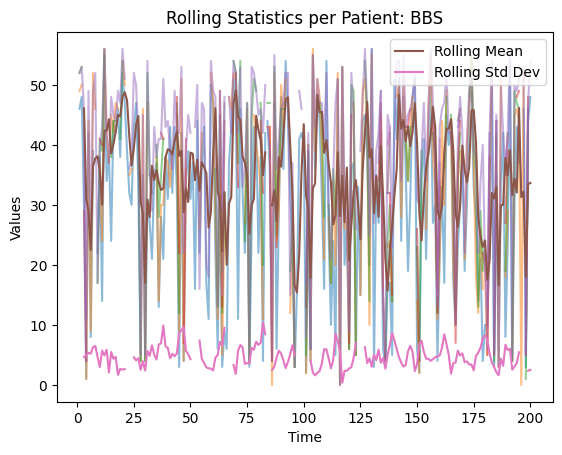

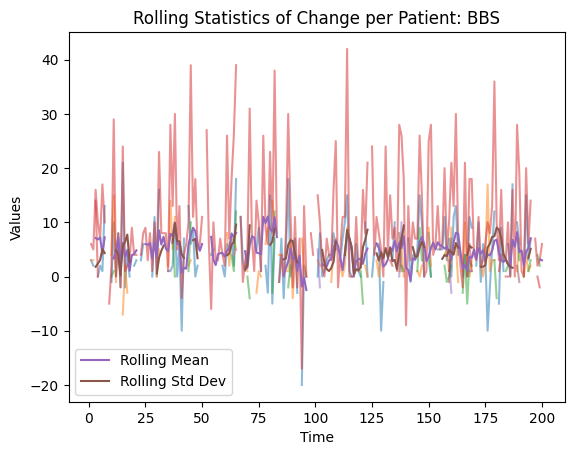

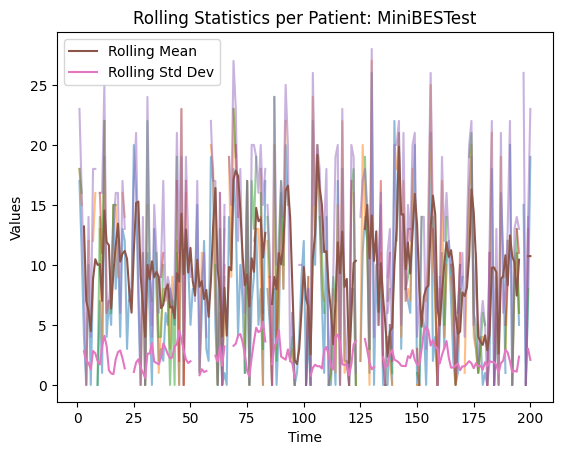

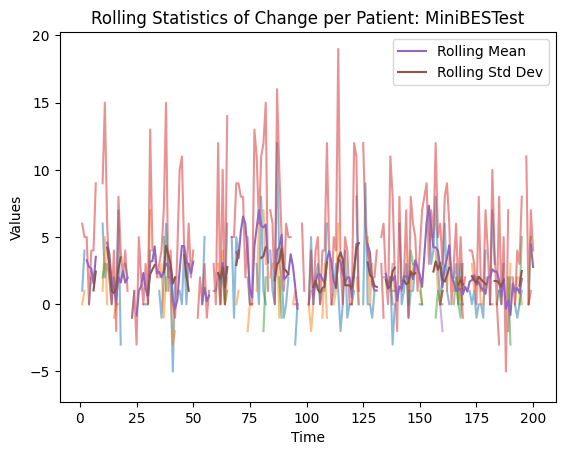

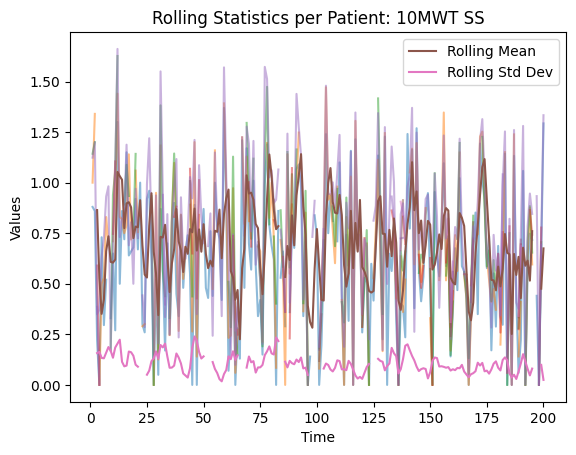

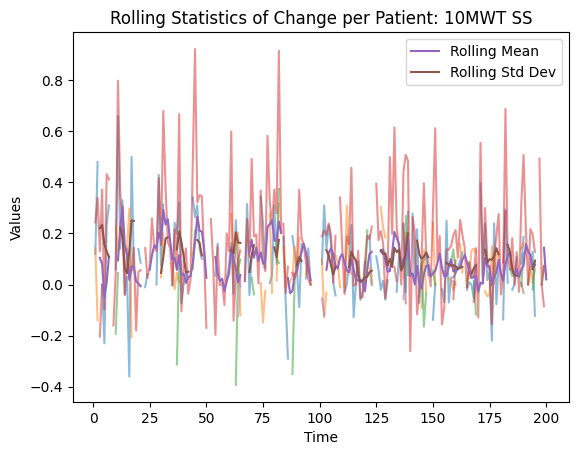

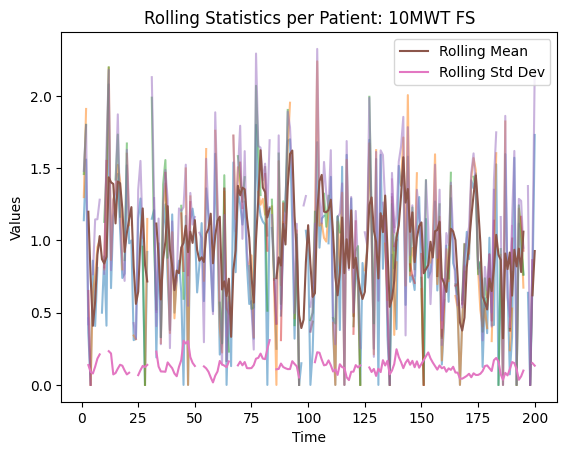

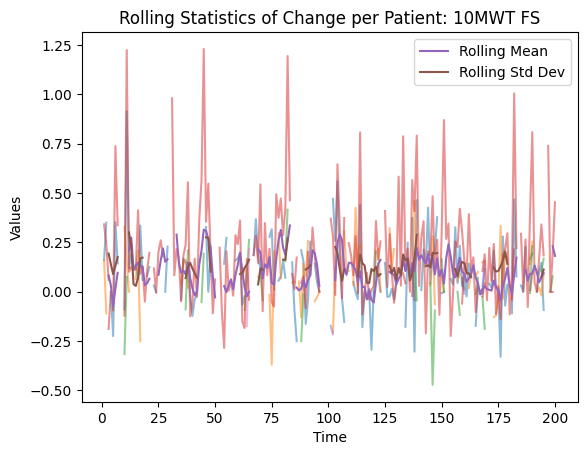

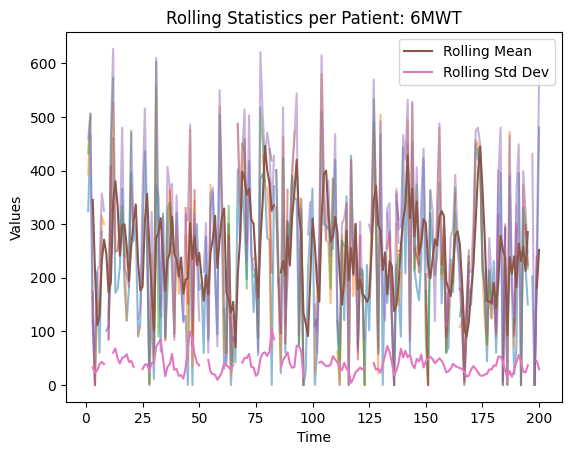

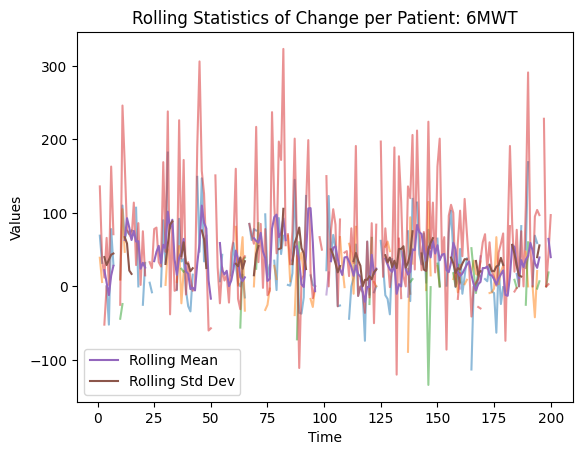

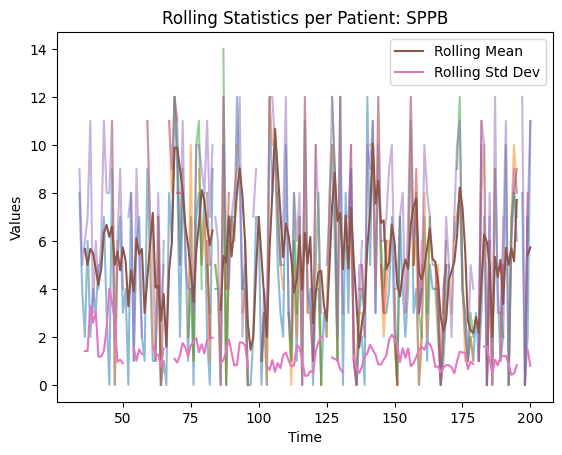

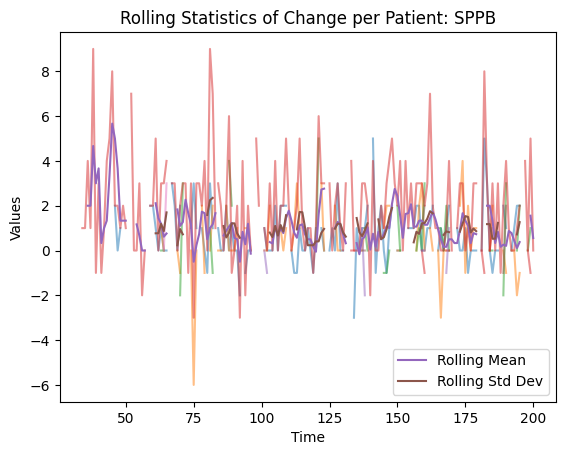

In [48]:
# Define the test names
test_names = ['BBS', 'MiniBESTest', '10MWT SS', '10MWT FS', '6MWT', 'SPPB']

# Define the window size for rolling statistics
window = 3

# Replace non-numeric values with NaN
df.replace('-', np.nan, inplace=True)

# Function to plot rolling statistics
def plot_rolling_statistics(df, title):
    # Calculate rolling mean and standard deviation
    rolling_mean = df.mean(axis=1).rolling(window=window).mean()
    rolling_std = df.std(axis=1).rolling(window=window).mean()

    # Plot the rolling statistics
    fig, ax = plt.subplots()
    ax.plot(df.index, df, alpha=0.5)
    ax.plot(df.index, rolling_mean, label='Rolling Mean')
    ax.plot(df.index, rolling_std, label='Rolling Std Dev')
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(title)
    plt.show()

# Calculate and plot rolling statistics for each test
for test_name in test_names:
    # Find the columns that contain the test name as a substring
    test_columns = [col for col in df.columns if test_name in col and "CHANGE" not in col]

    if test_columns:
        subset_df = df[test_columns].apply(pd.to_numeric, errors='coerce')
        plot_rolling_statistics(subset_df, f'Rolling Statistics per Patient: {test_name}')
    else:
        print(f"No test score columns found for test: {test_name}")

    # Find the columns that contain the word "CHANGE" related to the test
    change_columns = [col for col in df.columns if test_name in col and "CHANGE" in col]

    if change_columns:
        change_df = df[change_columns].apply(pd.to_numeric, errors='coerce')
        plot_rolling_statistics(change_df, f'Rolling Statistics of Change per Patient: {test_name}')
    else:
        print(f"No change columns found for test: {test_name}")


In [49]:
df.columns

Index(['BBS ADM', '10MWT SS ADM', '10MWT FS ADM', '6MWT ADM',
       'MiniBESTest ADM', 'SPPB ADM', 'BBS W1', 'BBS CHANGE ADM-W1',
       '10MWT SS W1', '10MWT SS CHANGE ADM-W1',
       ...
       '10MWT SS DC', '10MWT SS CHANGE ADM-DC', '10MWT FS DC',
       '10MWT FS CHANGE ADM-DC', '6MWT DC', '6MWT CHANGE ADM-DC',
       'MiniBESTest DC', 'MiniBESTest CHANGE ADM-DC', 'SPPB DC',
       'SPPB CHANGE ADM-DC'],
      dtype='object', length=174)

In [50]:
df.shape

(201, 174)

Applying forward and backward filling to deal with missing values

In [51]:
print("Before filling:")
print(df.head())

# Define the columns to forward fill
cols_to_forward_fill = ['BBS W5', '10MWT SS W5', '10MWT FS W5', '6MWT W5', 'MiniBESTest W5', 'SPPB W5', 'BBS W6', '10MWT SS W6', '10MWT FS W6', '6MWT W6', 'MiniBESTest W6', 'SPPB W6', 'BBS W7', '10MWT SS W7', '10MWT FS W7', '6MWT W7', 'MiniBESTest W7', 'SPPB W7', 'BBS W8', '10MWT SS W8', '10MWT FS W8', '6MWT W8', 'MiniBESTest W8', 'SPPB W8', 'BBS W9', '10MWT SS W9', '10MWT FS W9', '6MWT W9', 'MiniBESTest W9', 'SPPB W9', 'BBS W10', '10MWT SS W10', '10MWT FS W10', '6MWT W10', 'MiniBESTest W10', 'SPPB W10', 'BBS W11', '10MWT SS W11', '10MWT FS W11', '6MWT W11', 'MiniBESTest W11', 'SPPB W11', 'BBS W12', '10MWT SS W12', '10MWT FS W12', '6MWT W12', 'MiniBESTest W12', 'SPPB W12', 'BBS W13', '10MWT SS W13', '10MWT FS W13', '6MWT W13', 'MiniBESTest W13', 'SPPB W13', 'BBS DC', '10MWT SS DC', '10MWT FS DC', '6MWT DC', 'MiniBESTest DC', 'SPPB DC']

# Apply forward filling to selected columns
df[cols_to_forward_fill] = df[cols_to_forward_fill].fillna(method='ffill', axis=1)

# Define the columns to backward fill
cols_to_backward_fill = ['BBS ADM', '10MWT SS ADM', '10MWT FS ADM', '6MWT ADM', 'MiniBESTest ADM', 'SPPB ADM', 'BBS W1', '10MWT SS W1', '10MWT FS W1', '6MWT W1', 'MiniBESTest W1', 'SPPB W1', 'BBS W2', '10MWT SS W2', '10MWT FS W2', '6MWT W2', 'MiniBESTest W2', 'SPPB W2', 'BBS W3', '10MWT SS W3', '10MWT FS W3', '6MWT W3', 'MiniBESTest W3', 'SPPB W3', 'BBS W4', '10MWT SS W4', '10MWT FS W4', '6MWT W4', 'MiniBESTest W4', 'SPPB W4']

# Apply backward filling to selected columns
df[cols_to_backward_fill] = df[cols_to_backward_fill].fillna(method='bfill', axis=1)

# Print the DataFrame after filling
print("After filling:")
print(df.head())


Before filling:
     BBS ADM  10MWT SS ADM  10MWT FS ADM  6MWT ADM  MiniBESTest ADM  SPPB ADM  \
#                                                                               
1.0     46.0          0.88          1.14     324.0             17.0       NaN   
2.0     48.0          0.86          1.56     468.0             11.0       NaN   
3.0     30.0          0.22          0.36     113.0              4.0       NaN   
4.0      1.0          0.00          0.00       0.0              0.0       NaN   
5.0     42.0          0.73          0.86     210.0             10.0       NaN   

     BBS W1  BBS CHANGE ADM-W1  10MWT SS W1  10MWT SS CHANGE ADM-W1  ...  \
#                                                                    ...   
1.0    49.0                3.0         1.00                    0.12  ...   
2.0    50.0                2.0         1.34                    0.48  ...   
3.0     NaN                NaN          NaN                     NaN  ...   
4.0     1.0                0.0      

In [52]:
df.columns

Index(['BBS ADM', '10MWT SS ADM', '10MWT FS ADM', '6MWT ADM',
       'MiniBESTest ADM', 'SPPB ADM', 'BBS W1', 'BBS CHANGE ADM-W1',
       '10MWT SS W1', '10MWT SS CHANGE ADM-W1',
       ...
       '10MWT SS DC', '10MWT SS CHANGE ADM-DC', '10MWT FS DC',
       '10MWT FS CHANGE ADM-DC', '6MWT DC', '6MWT CHANGE ADM-DC',
       'MiniBESTest DC', 'MiniBESTest CHANGE ADM-DC', 'SPPB DC',
       'SPPB CHANGE ADM-DC'],
      dtype='object', length=174)

Hyperparameter Tuning

In [53]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import os

# Define the model
def create_model(learning_rate=0.01, preprocessing_type='standard'):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=(None, 1)))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer)
    return model

# Create a KerasRegressor instance
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 100],
    'epochs': [10],
    'learning_rate': [0.001, 0.1],
    'preprocessing_type': ['standard', 'minmax']
}

# Get unique patient IDs
patient_ids = df.index.dropna().unique()


# Initialize a dictionary to store the best hyperparameters for each patient and each test
pickle_file_path = '/content/gdrive/My Drive/Colab Notebooks/ML model/best_hyperparameters2.pickle'

# Create an empty file if it doesn't exist
if not os.path.exists(pickle_file_path):
    with open(pickle_file_path, 'wb') as f:
        pickle.dump({}, f)

# Load existing hyperparameters
with open(pickle_file_path, 'rb') as f:
    best_hyperparameters = pickle.load(f)

# Debug: Print the existing hyperparameters
print("Existing hyperparameters:", best_hyperparameters)

# Iterate over each patient
for patient_id in patient_ids:
    # Check if this patient has already been processed
    if any(key[0] == patient_id for key in best_hyperparameters.keys()):
        print(f"Skipping Patient {patient_id}: Already processed.")
        continue

    print(f"\nProcessing Patient {patient_id}:")

    # Get patient data
    patient_data = df.loc[patient_id]
    if isinstance(patient_data, pd.Series):
        patient_data = patient_data.to_frame().transpose()

    # Iterate over each test
    for test_name in ['BBS', '10MWT SS', '10MWT FS', '6MWT', 'MiniBESTest', 'SPPB']:
        print(f"\nTuning model for Test: {test_name}")

        # Get the columns for this test
        test_columns = [col for col in patient_data.columns if col.startswith(test_name)]
        patient_test = patient_data[test_columns]

        # Convert non-numeric values to NaN
        patient_test = patient_test.apply(pd.to_numeric, errors='coerce')

        # Drop missing values
        patient_test = patient_test.dropna(axis=1, how='all')

        # Check if there's enough data for this patient and this test
        if patient_test.shape[1] < 3:
            print(f"Not enough data for Patient {patient_id}, Test {test_name}. Skipping.")
            continue

        # Iterate over preprocessing types
        for preprocessing_type in param_grid['preprocessing_type']:
            # Preprocess patient data
            patient_test_scaled, scaler = preprocess_patient_data(patient_data, test_name, preprocessing_type)

            # Prepare the data for RNN [samples, timesteps, features]
            X_train = np.array([patient_test_scaled[i:i+2] for i in range(patient_test_scaled.shape[0] - 3)])
            y_train = np.array([patient_test_scaled[i+3] for i in range(patient_test_scaled.shape[0] - 3)])

            # Check if there are enough samples for cross-validation
            if len(X_train) < 5:
                print(f"Not enough samples for Patient {patient_id}, Test {test_name} for cross-validation. Skipping.")
                continue

            # Create Grid Search
            grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
            grid_result = grid.fit(X_train, y_train, callbacks=[EarlyStopping(monitor='loss', patience=3)])  # Stop training when the validation loss stops improving

            # Store the best hyperparameters
            best_hyperparameters[(patient_id, test_name, preprocessing_type)] = grid_result.best_params_

            # Summarize results
            print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
            means = grid_result.cv_results_['mean_test_score']
            stds = grid_result.cv_results_['std_test_score']
            params = grid_result.cv_results_['params']
            for mean, stdev, param in zip(means, stds, params):
                print(f"{mean} ({stdev}) with: {param}")

        # Save to Pickle file after processing each patient
        with open(pickle_file_path, 'wb') as f:
            pickle.dump(best_hyperparameters, f)


Existing hyperparameters: {(1.0, 'BBS', 'standard'): {'batch_size': 100, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (1.0, 'BBS', 'minmax'): {'batch_size': 100, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'standard'}, (2.0, 'BBS', 'standard'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'standard'}, (2.0, 'BBS', 'minmax'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '10MWT SS', 'standard'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '10MWT SS', 'minmax'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '10MWT FS', 'standard'): {'batch_size': 100, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'standard'}, (2.0, '10MWT FS', 'minmax'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '6MWT', 'standard'

<ipython-input-53-7e0575a9b2c9>:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Applying algorithms

In [54]:
print(best_hyperparameters.keys())


dict_keys([(1.0, 'BBS', 'standard'), (1.0, 'BBS', 'minmax'), (2.0, 'BBS', 'standard'), (2.0, 'BBS', 'minmax'), (2.0, '10MWT SS', 'standard'), (2.0, '10MWT SS', 'minmax'), (2.0, '10MWT FS', 'standard'), (2.0, '10MWT FS', 'minmax'), (2.0, '6MWT', 'standard'), (2.0, '6MWT', 'minmax'), (2.0, 'MiniBESTest', 'standard'), (2.0, 'MiniBESTest', 'minmax'), (2.0, 'SPPB', 'standard'), (2.0, 'SPPB', 'minmax'), (3.0, 'BBS', 'standard'), (3.0, 'BBS', 'minmax'), (3.0, '10MWT SS', 'standard'), (3.0, '10MWT SS', 'minmax'), (3.0, '10MWT FS', 'standard'), (3.0, '10MWT FS', 'minmax'), (3.0, '6MWT', 'standard'), (3.0, '6MWT', 'minmax'), (3.0, 'MiniBESTest', 'standard'), (3.0, 'MiniBESTest', 'minmax'), (3.0, 'SPPB', 'standard'), (3.0, 'SPPB', 'minmax'), (4.0, 'BBS', 'standard'), (4.0, 'BBS', 'minmax'), (4.0, '10MWT SS', 'standard'), (4.0, '10MWT SS', 'minmax'), (4.0, '10MWT FS', 'standard'), (4.0, '10MWT FS', 'minmax'), (4.0, '6MWT', 'standard'), (4.0, '6MWT', 'minmax'), (4.0, 'MiniBESTest', 'standard'), (4.

In [55]:
# Load best hyperparameters
with open('/content/gdrive/My Drive/Colab Notebooks/ML model/best_hyperparameters2.pickle', 'rb') as f:
    best_hyperparameters = pickle.load(f)

# Create a subset dictionary for the first two patients
subset_dict = {key: best_hyperparameters[key] for key in list(best_hyperparameters.keys())[:10]}  # Adjust this number as needed

# Print the subset dictionary
print(subset_dict)


{(1.0, 'BBS', 'standard'): {'batch_size': 100, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (1.0, 'BBS', 'minmax'): {'batch_size': 100, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'standard'}, (2.0, 'BBS', 'standard'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'standard'}, (2.0, 'BBS', 'minmax'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '10MWT SS', 'standard'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '10MWT SS', 'minmax'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '10MWT FS', 'standard'): {'batch_size': 100, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'standard'}, (2.0, '10MWT FS', 'minmax'): {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'preprocessing_type': 'minmax'}, (2.0, '6MWT', 'standard'): {'batch_size': 100, 'ep

In [56]:
import os
os.listdir("/content/gdrive/My Drive/Colab Notebooks/ML model/")


['my_scaler_117.0_SPPB.pkl',
 'my_model_117.0_SPPB_model_dir',
 'my_scaler_118.0_BBS.pkl',
 'my_model_118.0_BBS_model_dir',
 'my_scaler_118.0_10MWT SS.pkl',
 'my_model_118.0_10MWT SS_model_dir',
 'my_scaler_118.0_10MWT FS.pkl',
 'my_model_118.0_10MWT FS_model_dir',
 'my_scaler_118.0_6MWT.pkl',
 'my_model_118.0_6MWT_model_dir',
 'my_scaler_118.0_MiniBESTest.pkl',
 'my_model_118.0_MiniBESTest_model_dir',
 'my_scaler_118.0_SPPB.pkl',
 'my_model_118.0_SPPB_model_dir',
 'my_scaler_119.0_BBS.pkl',
 'my_model_119.0_BBS_model_dir',
 'my_scaler_119.0_10MWT SS.pkl',
 'my_model_119.0_10MWT SS_model_dir',
 'my_scaler_119.0_10MWT FS.pkl',
 'my_model_119.0_10MWT FS_model_dir',
 'my_scaler_119.0_6MWT.pkl',
 'my_model_119.0_6MWT_model_dir',
 'my_scaler_119.0_MiniBESTest.pkl',
 'my_model_119.0_MiniBESTest_model_dir',
 'my_scaler_119.0_SPPB.pkl',
 'my_model_119.0_SPPB_model_dir',
 'my_scaler_120.0_BBS.pkl',
 'my_model_120.0_BBS_model_dir',
 'my_scaler_120.0_10MWT SS.pkl',
 'my_model_120.0_10MWT SS_model

In [27]:
# Get unique patient IDs
patient_ids = df.index.dropna().unique()

RNN Model

In [57]:
from collections import defaultdict
import pickle
import os
import json
import shutil

# RNN Model Training

# Initialize dictionary to store the training history
model_history = {}

# Paths to saved results
actual_values_path = '/content/gdrive/My Drive/Colab Notebooks/ML model/actual_values.pkl'
predicted_values_path = '/content/gdrive/My Drive/Colab Notebooks/ML model/predicted_values.pkl'

# Load or initialize actual_values and predicted_values
if os.path.exists(actual_values_path):
    with open(actual_values_path, 'rb') as f:
        actual_values = pickle.load(f)
else:
    actual_values = defaultdict(list)

if os.path.exists(predicted_values_path):
    with open(predicted_values_path, 'rb') as f:
        predicted_values = pickle.load(f)
else:
    predicted_values = defaultdict(list)

# Get unique patient IDs
patient_ids = df.index.dropna().unique()

# Iterate over each patient
for patient_id in patient_ids:
    print(f"\nProcessing Patient {patient_id}:")

    # Get patient data
    patient_data = df.loc[patient_id]
    if isinstance(patient_data, pd.Series):
        patient_data = patient_data.to_frame().transpose()

    # Iterate over each test
    for test_name in ['BBS', '10MWT SS', '10MWT FS', '6MWT', 'MiniBESTest', 'SPPB']:

        # Derive the preprocessing_type based on the patient and test
        preprocessing_type = None
        for key in best_hyperparameters.keys():
            if key[0] == patient_id and key[1] == test_name:
                preprocessing_type = key[2]
                break

        # Check if we found the preprocessing type
        if not preprocessing_type:
            print(f"No hyperparameters found for Patient {patient_id}, Test {test_name}. Skipping.")
            continue

        best_params = best_hyperparameters[(patient_id, test_name, preprocessing_type)]
        learning_rate = best_params['learning_rate']
        batch_size = best_params['batch_size']
        epochs = best_params['epochs']

        # Define model path as a directory
        model_directory = f'/content/gdrive/My Drive/Colab Notebooks/ML model/my_model_{patient_id}_{test_name}_model_dir'

        # Check if model directory already exists for this patient and test
        if os.path.exists(model_directory):
            print(f"Model already exists for Patient {patient_id}, Test {test_name}. Skipping.")
            continue

        print(f"\nTest: {test_name}")

        # Preprocess patient data
        patient_test_scaled, scaler = preprocess_patient_data(patient_data, test_name, preprocessing_type)
        if patient_test_scaled is None:
            print(f"No data for Patient {patient_id}, Test {test_name}. Skipping.")
            continue

        # Save the scaler
        with open(f'/content/gdrive/My Drive/Colab Notebooks/ML model/my_scaler_{patient_id}_{test_name}.pkl', 'wb') as f:
            pickle.dump(scaler, f)

        # Check if there's enough data for this patient and this test
        if patient_test_scaled.shape[0] < 3:
            print(f"Not enough data for Patient {patient_id}, Test {test_name}. Skipping.")
            continue

        # Iterate over the data, using all previous weeks to predict the next week
        for i in range(2, 15):
            train_data = patient_test_scaled[:i]
            test_data = patient_test_scaled[i]

            # Reshape data for RNN [samples, timesteps, features]
            X_train = np.array([train_data])
            y_train = np.array([train_data[-1]])  # Predict the last week in our sequence
            X_test = np.array([[test_data]])
            y_test = np.array([test_data])

            # Create and train the RNN model
            model = create_model(learning_rate)
            model, history = train_model(model, X_train, y_train, batch_size, epochs)

            # Save the training history
            model_history[f'{patient_id}_{test_name}'] = {
                'loss': [float(value) for value in history.history['loss']]
            }

            # Save the model
            print(f"Saving model to: {model_directory}")  # Logging
            temp_model_directory = model_directory + '_temp'  # Create a temporary model directory
            model.save(temp_model_directory)  # Save to the temporary directory first
            print(f"Model saved to temporary location: {temp_model_directory}")  # Logging

            # Check if a directory with the target model name exists, and if so, delete it
            if os.path.isdir(model_directory):
                shutil.rmtree(model_directory)  # Use shutil.rmtree to delete directories
                print(f"Deleted existing directory: {model_directory}")  # Logging

            shutil.move(temp_model_directory, model_directory)  # Using shutil.move() instead of os.rename()
            print(f"Model moved to final location: {model_directory}")  # Logging

            # Make the prediction and evaluate
            prediction, actual_value = predict_and_evaluate(model, X_test, y_test, scaler)

            # Print the prediction and the actual value
            print(f"Week {i+1} - Predicted: {prediction}, Actual: {actual_value}")

            # Store the actual and predicted values in dictionaries
            actual_values[f'{patient_id}_{test_name}'].append(actual_value)
            predicted_values[f'{patient_id}_{test_name}'].append(prediction)

            # Save the actual_values and predicted_values dictionaries after each test
            with open(actual_values_path, 'wb') as f:
                pickle.dump(actual_values, f)
            with open(predicted_values_path, 'wb') as f:
                pickle.dump(predicted_values, f)



Processing Patient 1.0:
Model already exists for Patient 1.0, Test BBS. Skipping.
No hyperparameters found for Patient 1.0, Test 10MWT SS. Skipping.
No hyperparameters found for Patient 1.0, Test 10MWT FS. Skipping.
No hyperparameters found for Patient 1.0, Test 6MWT. Skipping.
No hyperparameters found for Patient 1.0, Test MiniBESTest. Skipping.
No hyperparameters found for Patient 1.0, Test SPPB. Skipping.

Processing Patient 2.0:
Model already exists for Patient 2.0, Test BBS. Skipping.
Model already exists for Patient 2.0, Test 10MWT SS. Skipping.
Model already exists for Patient 2.0, Test 10MWT FS. Skipping.
Model already exists for Patient 2.0, Test 6MWT. Skipping.
Model already exists for Patient 2.0, Test MiniBESTest. Skipping.
Model already exists for Patient 2.0, Test SPPB. Skipping.

Processing Patient 3.0:
Model already exists for Patient 3.0, Test BBS. Skipping.
Model already exists for Patient 3.0, Test 10MWT SS. Skipping.
Model already exists for Patient 3.0, Test 10MWT

Persistence Model

In [58]:
from collections import defaultdict

# Initialize dictionaries to store the persistence forecast values and actual values
persistence_forecast_values = defaultdict(list)
corresponding_actual_values_persistence = defaultdict(list)

n = 3  # The same 'n' used in the Naive model

def run_persistence_model(patient_data, test_name):
    test_columns = [col for col in patient_data.columns if col.startswith(test_name)]
    patient_test_data = patient_data[test_columns].iloc[0]
    patient_test_data = patient_test_data.dropna()

    if len(patient_test_data) < n+1:
        print(f"Insufficient data for Persistence Model for {test_name}.")
        return None, None

    # Create the persistence forecast and corresponding actual values
    persistence_forecast = patient_test_data[:-(n+1)].values
    actual_values = patient_test_data[n:].values

    return persistence_forecast, actual_values

# Your patient IDs, make sure it's defined
patient_ids = df.index.unique()

# Iterate over each patient
for patient_id in patient_ids:
    print(f"\nProcessing Patient {patient_id}:")

    patient_data = df.loc[patient_id:patient_id]

    for test_name in ['BBS', '10MWT SS', '10MWT FS', '6MWT', 'MiniBESTest', 'SPPB']:
        print(f"\nTest: {test_name}")

        persistence_vals, actual_vals = run_persistence_model(patient_data, test_name)

        if persistence_vals is None:
            continue

        key = f'{patient_id}_{test_name}'

        persistence_forecast_values[key].extend(persistence_vals)
        corresponding_actual_values_persistence[key].extend(actual_vals)

        print(f"Length of persistence_forecast_values[{key}] after extend: {len(persistence_forecast_values[key])}")
        print(f"Length of corresponding_actual_values_persistence[{key}] after extend: {len(corresponding_actual_values_persistence[key])}")

# Save the dictionaries
with open('/content/gdrive/My Drive/Colab Notebooks/persistence_forecast_values.pkl', 'wb') as f:
    pickle.dump(persistence_forecast_values, f)

with open('/content/gdrive/My Drive/Colab Notebooks/corresponding_actual_values_persistence.pkl', 'wb') as f:
    pickle.dump(corresponding_actual_values_persistence, f)


Strømmer utdata som er avkortet til de siste 5000 linjene.
Test: 10MWT SS
Length of persistence_forecast_values[2.0_10MWT SS] after extend: 3
Length of corresponding_actual_values_persistence[2.0_10MWT SS] after extend: 4

Test: 10MWT FS
Length of persistence_forecast_values[2.0_10MWT FS] after extend: 3
Length of corresponding_actual_values_persistence[2.0_10MWT FS] after extend: 4

Test: 6MWT
Length of persistence_forecast_values[2.0_6MWT] after extend: 3
Length of corresponding_actual_values_persistence[2.0_6MWT] after extend: 4

Test: MiniBESTest
Length of persistence_forecast_values[2.0_MiniBESTest] after extend: 3
Length of corresponding_actual_values_persistence[2.0_MiniBESTest] after extend: 4

Test: SPPB
Insufficient data for Persistence Model for SPPB.

Processing Patient 3.0:

Test: BBS
Length of persistence_forecast_values[3.0_BBS] after extend: 4
Length of corresponding_actual_values_persistence[3.0_BBS] after extend: 5

Test: 10MWT SS
Length of persistence_forecast_values

Naive baseline model

In [59]:
from collections import defaultdict

def run_avg_naive_forecast(patient_data, test_name, n=3):
    test_columns = [col for col in patient_data.columns if col.startswith(test_name)]
    patient_test_data = patient_data[test_columns].iloc[0]
    patient_test_data = patient_test_data.dropna()

    if len(patient_test_data) < n+1:
        print(f"Insufficient data for Naive Forecast for {test_name}.")
        return None, None

    # Create the naive forecast and corresponding actual values
    naive_forecast = [np.mean(patient_test_data[i-n:i]) for i in range(n, len(patient_test_data))]
    actual_values = patient_test_data[n:].values

    return naive_forecast, actual_values

# Initialize dictionaries to store the naive forecast values and actual values
avg_naive_forecast_values = defaultdict(list)
corresponding_actual_values_avg_naive = defaultdict(list)

# Your patient IDs, make sure it's defined
patient_ids = df.index.unique()

# Iterate over each patient
for patient_id in patient_ids:
    print(f"\nProcessing Patient {patient_id}:")

    patient_data = df.loc[patient_id:patient_id]

    for test_name in ['BBS', '10MWT SS', '10MWT FS', '6MWT', 'MiniBESTest', 'SPPB']:
        print(f"\nTest: {test_name}")

        naive_vals, actual_vals = run_avg_naive_forecast(patient_data, test_name)

        if naive_vals is None:
            continue

        key = f'{patient_id}_{test_name}'

        avg_naive_forecast_values[key].extend(naive_vals)
        corresponding_actual_values_avg_naive[key].extend(actual_vals)

        print(f"Length of avg_naive_forecast_values[{key}] after extend: {len(avg_naive_forecast_values[key])}")
        print(f"Length of corresponding_actual_values_avg_naive[{key}] after extend: {len(corresponding_actual_values_avg_naive[key])}")

# Save the dictionaries
with open('/content/gdrive/My Drive/Colab Notebooks/avg_naive_forecast_values.pkl', 'wb') as f:
    pickle.dump(avg_naive_forecast_values, f)

with open('/content/gdrive/My Drive/Colab Notebooks/corresponding_actual_values_avg_naive.pkl', 'wb') as f:
    pickle.dump(corresponding_actual_values_avg_naive, f)


Strømmer utdata som er avkortet til de siste 5000 linjene.
Test: 10MWT SS
Length of avg_naive_forecast_values[2.0_10MWT SS] after extend: 4
Length of corresponding_actual_values_avg_naive[2.0_10MWT SS] after extend: 4

Test: 10MWT FS
Length of avg_naive_forecast_values[2.0_10MWT FS] after extend: 4
Length of corresponding_actual_values_avg_naive[2.0_10MWT FS] after extend: 4

Test: 6MWT
Length of avg_naive_forecast_values[2.0_6MWT] after extend: 4
Length of corresponding_actual_values_avg_naive[2.0_6MWT] after extend: 4

Test: MiniBESTest
Length of avg_naive_forecast_values[2.0_MiniBESTest] after extend: 4
Length of corresponding_actual_values_avg_naive[2.0_MiniBESTest] after extend: 4

Test: SPPB
Insufficient data for Naive Forecast for SPPB.

Processing Patient 3.0:

Test: BBS
Length of avg_naive_forecast_values[3.0_BBS] after extend: 5
Length of corresponding_actual_values_avg_naive[3.0_BBS] after extend: 5

Test: 10MWT SS
Length of avg_naive_forecast_values[3.0_10MWT SS] after exte

Model Evaluation

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pickle
from collections import defaultdict

# Function to align sequences
def align_sequences(actual, predicted):
    aligned_actual = {}
    aligned_predicted = {}
    for key in actual:
        if key not in predicted:
            print(f"Warning: Missing key '{key}' in predicted values.")
            continue
        len_actual = len(actual[key])
        len_pred = len(predicted[key])
        if len_actual != len_pred:
            print(f"Warning: Length mismatch for key '{key}'. Actual: {len_actual}, Predicted: {len_pred}")
            min_len = min(len_actual, len_pred)
            aligned_actual[key] = actual[key][:min_len]
            aligned_predicted[key] = predicted[key][:min_len]
        else:
            aligned_actual[key] = actual[key]
            aligned_predicted[key] = predicted[key]
    return aligned_actual, aligned_predicted

# Function to safely calculate mean_squared_error
def safe_mse(a, p):
    return mean_squared_error(a, p) if len(a) > 0 and len(p) > 0 else None

# Function to safely calculate mean_absolute_error
def safe_mae(a, p):
    return mean_absolute_error(a, p) if len(a) > 0 and len(p) > 0 else None

# Align lengths and check
aligned_actual_values_rnn, aligned_predicted_values_rnn = align_sequences(actual_values_rnn, predicted_values_rnn)
aligned_actual_values_persistence, aligned_persistence_forecast_values = align_sequences(actual_values_persistence, persistence_forecast_values)

# Calculate the Mean Squared Error for each model
mse_rnn = {key: safe_mse(aligned_actual_values_rnn[key], aligned_predicted_values_rnn[key]) for key in aligned_actual_values_rnn}
mse_naive = {key: safe_mse(actual_values_naive[key], naive_forecast_values[key]) for key in actual_values_naive}
mse_persistence = {key: safe_mse(aligned_actual_values_persistence[key], aligned_persistence_forecast_values[key]) for key in aligned_actual_values_persistence}

# Calculate the Root Mean Squared Error for each model
rmse_rnn = {key: np.sqrt(val) if val is not None else None for key, val in mse_rnn.items()}
rmse_naive = {key: np.sqrt(val) if val is not None else None for key, val in mse_naive.items()}
rmse_persistence = {key: np.sqrt(val) if val is not None else None for key, val in mse_persistence.items()}

# Calculate the Mean Absolute Error for each model
mae_rnn = {key: safe_mae(aligned_actual_values_rnn[key], aligned_predicted_values_rnn[key]) for key in aligned_actual_values_rnn}
mae_naive = {key: safe_mae(actual_values_naive[key], naive_forecast_values[key]) for key in actual_values_naive}
mae_persistence = {key: safe_mae(aligned_actual_values_persistence[key], aligned_persistence_forecast_values[key]) for key in aligned_actual_values_persistence}

# Print the metrics for each model
print("Mean Squared Error for RNN model:", mse_rnn)
print("Mean Squared Error for Naive Baseline model:", mse_naive)
print("Mean Squared Error for Persistence model:", mse_persistence)

print("Root Mean Squared Error for RNN model:", rmse_rnn)
print("Root Mean Squared Error for Naive Baseline model:", rmse_naive)
print("Root Mean Squared Error for Persistence model:", rmse_persistence)

print("Mean Absolute Error for RNN model:", mae_rnn)
print("Mean Absolute Error for Naive Baseline model:", mae_naive)
print("Mean Absolute Error for Persistence model:", mae_persistence)

# Define the path to save the evaluation results
eval_results_path = '/content/gdrive/My Drive/Colab Notebooks/evaluation_results.pkl'

# Create a dictionary to store all evaluation metrics
evaluation_results = {
    'mse_rnn': mse_rnn,
    'mse_naive': mse_naive,
    'mse_persistence': mse_persistence,
    'rmse_rnn': rmse_rnn,
    'rmse_naive': rmse_naive,
    'rmse_persistence': rmse_persistence,
    'mae_rnn': mae_rnn,
    'mae_naive': mae_naive,
    'mae_persistence': mae_persistence
}

# Save the evaluation_results dictionary to a pickle file
with open(eval_results_path, 'wb') as f:
    pickle.dump(evaluation_results, f)

print(f"Evaluation results saved to {eval_results_path}")


Mean Squared Error for RNN model: {'1.0_BBS': 447.3894317704502, '2.0_BBS': 1002.0577954587689, '2.0_10MWT SS': 0.7884382415604704, '2.0_10MWT FS': 0.9900183586774888, '2.0_6MWT': 20033.57629796679, '2.0_MiniBESTest': 25.19165285693849, '2.0_SPPB': 0.9212569189175936, '3.0_BBS': 233.33323252005346, '3.0_10MWT SS': 0.0679640684210244, '3.0_10MWT FS': 0.05663318935185609, '3.0_6MWT': 3428.2360404355973, '3.0_MiniBESTest': 0.004573841365481535, '3.0_SPPB': 0.0035554244135119744, '4.0_BBS': 10.166924967208502, '4.0_10MWT SS': 0.5681722505797364, '4.0_10MWT FS': 0.5867087773618956, '4.0_6MWT': 2.368894983344285, '4.0_MiniBESTest': 0.5526683599192196, '4.0_SPPB': 0.5639675596573922, '5.0_BBS': 0.7721767544858579, '5.0_10MWT SS': 0.11636855396485958, '5.0_10MWT FS': 0.098723988301841, '5.0_6MWT': 365.8318192493717, '5.0_MiniBESTest': 0.6217447510930982, '5.0_SPPB': 0.13911794679341152, '6.0_BBS': 95.75221756797033, '6.0_10MWT SS': 8.686469776253785, '6.0_10MWT FS': 9.443272317147539, '6.0_6MW

Post-modelig Correlation Analysis

In [ ]:
def post_modeling_correlation_analysis(actual_values, predicted_values_rnn, predicted_values_model2):
    for key in actual_values.keys():
        actual = actual_values[key]
        predicted_rnn = predicted_values_rnn.get(key, [None]*len(actual))  # Use default if no predictions
        predicted_model2 = predicted_values_model2.get(key, [None]*len(actual))

        df_results = pd.DataFrame({
            'Actual': actual,
            'Predicted_RNN': predicted_rnn,
            'Predicted_Model2': predicted_model2
        })

        # Compute the correlation of predictions with actual values
        correlations = df_results.corr()['Actual']
        print(f"Correlations for {key}:\n{correlations}\n{'-'*50}")

# Assuming at this point `actual_values`, `predicted_values_rnn`, and `predicted_values_model2` dictionaries are populated
post_modeling_correlation_analysis(actual_values, predicted_values_rnn, predicted_values_model2)


Loading the saved results of the RNN model back into the memory in case of disconnection

In [ ]:
from tensorflow.keras.models import load_model
import pickle
import os

# Initialize dictionaries to store the models
models = {}

# Paths to actual_values and predicted_values files
actual_values_path = '/content/gdrive/My Drive/Colab Notebooks/ML model/actual_values.pkl'
predicted_values_path = '/content/gdrive/My Drive/Colab Notebooks/ML model/predicted_values.pkl'

# Load the actual values and predicted values
with open(actual_values_path, 'rb') as f:
    actual_values = pickle.load(f)
with open(predicted_values_path, 'rb') as f:
    predicted_values = pickle.load(f)

# Iterate over each patient and each test
for patient_id in patient_ids:
    for test_name in ['BBS', '10MWT SS', '10MWT FS', '6MWT', 'MiniBESTest', 'SPPB']:
        model_path = f'/content/gdrive/My Drive/Colab Notebooks/ML model/my_model_{patient_id}_{test_name.replace(" ", "_")}.h5'

        print(f"Attempting to load model for Patient {patient_id}, Test {test_name}.")
        print(f"Model file path: {model_path}")

        # Check if the model file exists
        if not os.path.exists(model_path):
            print(f"Model file does not exist for Patient {patient_id}, Test {test_name}. Skipping.")
            continue

        print(f"Loading model for Patient {patient_id}, Test {test_name}")

        # Load the model
        models[f'{patient_id}_{test_name}'] = load_model(model_path)

print("\nKeys in models dictionary:")
print(models.keys())

print("\nKeys in actual_values dictionary:")
print(actual_values.keys())

print("\nKeys in predicted_values dictionary:")
print(predicted_values.keys())


Attempting to load model for Patient 1, Test BBS.
Model file path: /content/gdrive/My Drive/Colab Notebooks/ML model/my_model_1_BBS.h5
Model file does not exist for Patient 1, Test BBS. Skipping.
Attempting to load model for Patient 1, Test 10MWT SS.
Model file path: /content/gdrive/My Drive/Colab Notebooks/ML model/my_model_1_10MWT_SS.h5
Model file does not exist for Patient 1, Test 10MWT SS. Skipping.
Attempting to load model for Patient 1, Test 10MWT FS.
Model file path: /content/gdrive/My Drive/Colab Notebooks/ML model/my_model_1_10MWT_FS.h5
Model file does not exist for Patient 1, Test 10MWT FS. Skipping.
Attempting to load model for Patient 1, Test 6MWT.
Model file path: /content/gdrive/My Drive/Colab Notebooks/ML model/my_model_1_6MWT.h5
Model file does not exist for Patient 1, Test 6MWT. Skipping.
Attempting to load model for Patient 1, Test MiniBESTest.
Model file path: /content/gdrive/My Drive/Colab Notebooks/ML model/my_model_1_MiniBESTest.h5
Model file does not exist for Pa

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values - all patients and all tests
plt.figure(figsize=(8, 8))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Plot of residuals over time - all patients and all tests
residuals = np.array(actual_values) - np.array(predicted_values)
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals over Time')
plt.show()
